## Project 4: Exploring the RSA's machinery imports and exports

A country's economy depends, sometimes heavily, on its exports and imports. The United Nations Comtrade database provides data on global trade. It will be used to analyse SA's imports and exports of milk and cream in 2015:

- How much does SA export and import and is the balance positive (more exports than imports)? 
- Which are the main trading partners, i.e. from/to which countries does the SA import/export the most?
- Which are the regular customers, i.e. which countries buy machinery from the SA every month?
- Which countries does SA both import from and export to?

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from pandas import *
%matplotlib inline

## Getting and preparing the data

The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: monthly 
- Periods: January to May of 2015
- Reporter: United Kingdom
- Partners: all
- Flows: imports and exports
- HS (as reported) commodity codes: 0401 (Milk and cream, neither concentrated nor sweetened) and 0402 (Milk and cream, concentrated or sweetened)

Clicking on 'Preview' results in a message that the data exceeds 500 rows. Data was downloaded using the *Download CSV* button and the download file renamed appropriately.

In [13]:
commodity= 'comtrade_machinery_sa_jan_may_15.csv'

The data can also be downloaded directly from Comtrade using the "View API Call" URL, modified in two ways:

- `max=500` is increased to `max=5000` to make sure all data is loaded,
- `&fmt=csv` is added at the end to obtain the data in CSV format.

In [ ]:
# LOCATION = 'http://comtrade.un.org/api/get?max=5000&type=C&freq=M&px=HS&ps=201505%2C201504%2C201503%2C201502%2C201501&r=826&p=all&rg=1%2C2&cc=0401%2C0402&fmt=csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [14]:
machinery = read_csv(commodity, dtype={'Commodity Code':str})
machinery.head()

,Classification,Year,Period,Period Desc.,Aggregate Level,Is Leaf Code,Trade Flow Code,Trade Flow,Reporter Code,Reporter,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
0,HS,2019,201905,May 2019,6,1,2,Exports,710,South Africa,...,NaN,NaN,NaN,NaN,16843,NaN,14589,NaN,NaN,0
1,HS,2019,201901,January 2019,6,1,1,Imports,710,South Africa,...,NaN,NaN,NaN,NaN,1501,NaN,33229,NaN,NaN,0
2,HS,2019,201903,March 2019,6,1,2,Exports,710,South Africa,...,NaN,NaN,NaN,NaN,8049,NaN,25408,NaN,NaN,0
3,HS,2019,201905,May 2019,6,1,2,Exports,710,South Africa,...,NaN,NaN,NaN,NaN,20396,NaN,48706,NaN,NaN,0
4,HS,2019,201905,May 2019,6,1,2,Exports,710,South Africa,...,NaN,NaN,NaN,NaN,164,NaN,1197,NaN,NaN,0


# The data only covers the last five months of 2020. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [15]:
def machineType(code):
    if code == '731412': # neither concentrated nor sweetened
        return 'stainless steel'
    if code == '731412': # concentrated or sweetened
        return 'non stainless steel' 
    return 'unknown'

COMMODITY = 'steel machinery'
machinery[COMMODITY] = machinery['Commodity Code'].apply(machineType)
MONTH = 'Period'
PARTNER = 'Partner'
FLOW = 'Trade Flow'
VALUE = 'Trade Value (US$)'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
machinery = machinery[headings]
machinery.head()

,Period,Partner,Trade Flow,steel machinery,Trade Value (US$)
0,201905,Botswana,Exports,stainless steel,14589
1,201901,World,Imports,stainless steel,33229
2,201903,Sierra Leone,Exports,stainless steel,25408
3,201905,Swaziland,Exports,stainless steel,48706
4,201905,Mozambique,Exports,stainless steel,1197


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [16]:
machinery = machinery[machinery[PARTNER] != 'World']
machinery.head()

,Period,Partner,Trade Flow,steel machinery,Trade Value (US$)
0,201905,Botswana,Exports,stainless steel,14589
2,201903,Sierra Leone,Exports,stainless steel,25408
3,201905,Swaziland,Exports,stainless steel,48706
4,201905,Mozambique,Exports,stainless steel,1197
5,201902,Bunkers,Exports,stainless steel,100


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [17]:
grouped = machinery.groupby([FLOW])
grouped[VALUE].aggregate(sum)

Trade Flow
Exports    657624
Imports    120023
Name: Trade Value (US$), dtype: int64

This shows a trade surplus of over 5 million dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [18]:
imports = machinery[machinery[FLOW] == 'Imports']
grouped = imports.groupby([PARTNER])
print('SA imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to SA are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False)
totalImports.head()

SA imports from 13 countries.
The 5 biggest exporters to SA are:


Partner
United Kingdom              33605
United States of America    21723
Germany                     18495
Belgium                     13831
China                       12522
Name: Trade Value (US$), dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

<AxesSubplot:ylabel='Partner'>

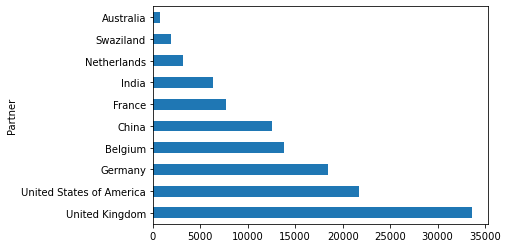

In [19]:
totalImports.head(10).plot(kind='barh')

In [20]:
exports = machinery[machinery[FLOW] == 'Exports']
grouped = exports.groupby([PARTNER])
print('SA exports to', len(grouped), 'countries.')
print('The 5 biggest importers from SA are:')
grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).head()

SA exports to 17 countries.
The 5 biggest importers from SA are:


Partner
Swaziland       133542
Sierra Leone     99266
Botswana         92282
Lesotho          91440
Namibia          73358
Name: Trade Value (US$), dtype: int64

## Regular importers

Given that there are two commodities, the third question, 'Which are the regular customers, i.e. which countries buy machinery from SA every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the exports dataframe is grouped by country, each group has exactly ten rows (two commodities bought each of the five months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [21]:
def buysEveryMonth(group):
    return len(group) == 10

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular[(regular[MONTH] == 201501) & (regular[COMMODITY] == 'processed')]

,Period,Partner,Trade Flow,steel machinery,Trade Value (US$)


Just over 75% of the total UK exports are due to these regular customers.

In [22]:
regular[VALUE].sum() / exports[VALUE].sum()

0.0

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [24]:
countries = pivot_table(machinery, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

Trade Flow,Exports,Imports
Partner,,
Australia,NaN,700.0
Belgium,NaN,13831.0
Benin,17.0,NaN
Botswana,92282.0,NaN
Bunkers,9119.0,NaN


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with SA.

In [ ]:
countries.dropna()

## Conclusions

The machinery trade of SA from January to May 2019 was analysed in terms of which countries SA mostly depends on for income (exports) and goods (imports). Over the period, SA had a trade surplus of over 5 million US dollars.

United Kingdom are the main importing partner and Swaziland is the main exporting partner. 

SA exported to 17 countries during the period, but only imported from 13 countries.

There are no regulars or monthly exports to a certain country. This is probably because the product at hand is not a need like food.

SA has no bi-directional trade (i.e. both exports and imports). It imports mostly from other continents, which do not import from SA as much as African countries.


## Now repeat the analysis with your own data gotten from Comtrade website